<a href="https://colab.research.google.com/github/PAPANPANG/PAPANPANG/blob/main/Sand_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install numpy matplotlib opencv-python-headless scikit-learn

In [26]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


从图像1到图像2，x方向的实际移动距离（mm）:  -0.40411896
从图像1到图像2，y方向的实际移动距离（mm）:  0.17533562
从图像2到图像3，x方向的实际移动距离（mm）:  101.8938
从图像2到图像3，y方向的实际移动距离（mm）:  21.704153


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27801 (\N{CJK UNIFIED IDEOGRAPH-6C99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19992 (\N{CJK UNIFIED IDEOGRAPH-4E18}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

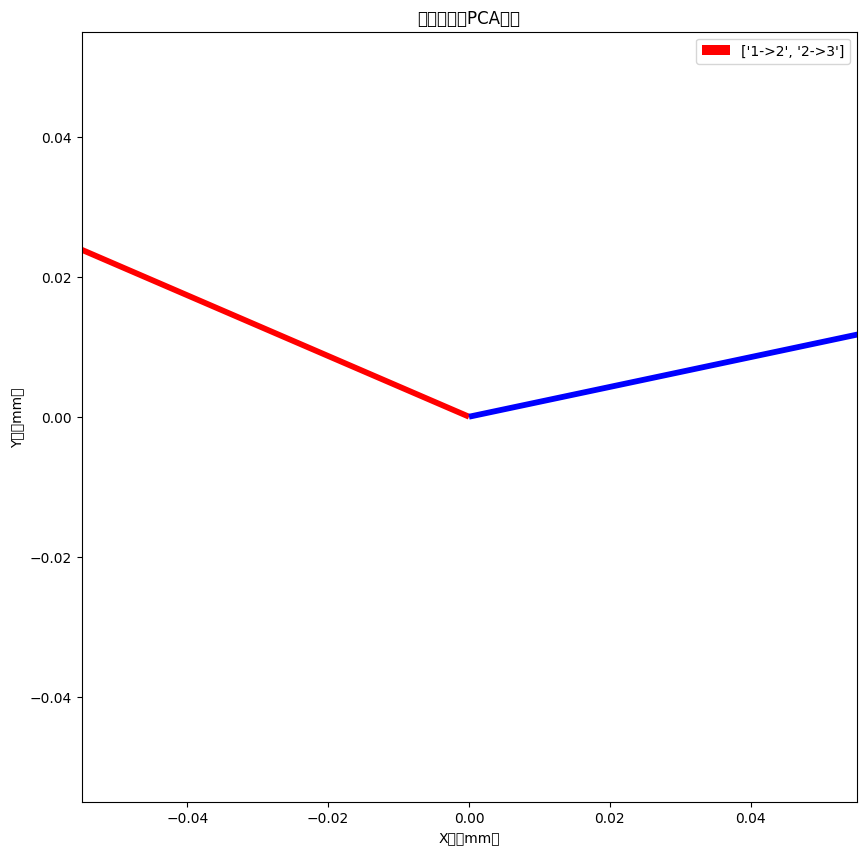

In [28]:
# 加载图像
image1 = cv2.imread('/content/drive/My Drive/SAND_TEST/T_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/My Drive/SAND_TEST/T_2.jpg', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('/content/drive/My Drive/SAND_TEST/T_3.jpg', cv2.IMREAD_GRAYSCALE)

# 获取图像尺寸（像素）
img_height, img_width = image1.shape

# 实际宽度和高度（单位：mm）
real_width = 496.1
real_height = 350.8

# 定义一个函数来找到图像中的关键点
def find_keypoints(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# 在所有图像中找到关键点和描述符
kp1, des1 = find_keypoints(image1)
kp2, des2 = find_keypoints(image2)
kp3, des3 = find_keypoints(image3)

# 使用BFMatcher找到图像之间的最佳匹配
bf = cv2.BFMatcher()
matches12 = bf.knnMatch(des1, des2, k=2)
matches23 = bf.knnMatch(des2, des3, k=2)

# 应用比率测试以保留好的匹配
good_matches12 = [m for m, n in matches12 if m.distance < 0.75 * n.distance]
good_matches23 = [m for m, n in matches23 if m.distance < 0.75 * n.distance]

# 提取好的匹配点的位置
def get_match_points(keypoints1, keypoints2, matches):
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
    return pts1, pts2

pts1_2, pts2_2 = get_match_points(kp1, kp2, good_matches12)
pts2_3, pts3_3 = get_match_points(kp2, kp3, good_matches23)

# 连接所有匹配点以进行PCA分析
all_points1 = np.concatenate((pts1_2, pts2_2), axis=0)
all_points2 = np.concatenate((pts2_2, pts3_3), axis=0)

# 将图像坐标转换为实际物理距离（mm）
all_points1[:, 0] *= (real_width / img_width)
all_points1[:, 1] *= (real_height / img_height)
all_points2[:, 0] *= (real_width / img_width)
all_points2[:, 1] *= (real_height / img_height)

# 执行PCA分析
pca1 = PCA(n_components=2)
transformed_points1 = pca1.fit_transform(all_points1)

pca2 = PCA(n_components=2)
transformed_points2 = pca2.fit_transform(all_points2)

# 确保匹配的点数量相同
min_len1 = min(len(pts1_2), len(pts2_2))
min_len2 = min(len(pts2_2), len(pts3_3))

# 重新整理数组以匹配点数
transformed_points1 = transformed_points1[:min_len1 + min_len1]
transformed_points2 = transformed_points2[:min_len2 + min_len2]

# 计算主要成分的均值，代表沙丘的移动
mean_movement1_2 = np.mean(transformed_points1[min_len1:] - transformed_points1[:min_len1], axis=0)
mean_movement2_3 = np.mean(transformed_points2[min_len2:] - transformed_points2[:min_len2], axis=0)

# 获取PCA的两个主成分方向向量
principal_directions1 = pca1.components_
principal_directions2 = pca2.components_

# 计算主要成分在原始坐标系中的表示
mean_movement1_2_original = np.dot(mean_movement1_2, principal_directions1)
mean_movement2_3_original = np.dot(mean_movement2_3, principal_directions2)

print("从图像1到图像2，x方向的实际移动距离（mm）: ", mean_movement1_2_original[0])
print("从图像1到图像2，y方向的实际移动距离（mm）: ", mean_movement1_2_original[1])
print("从图像2到图像3，x方向的实际移动距离（mm）: ", mean_movement2_3_original[0])
print("从图像2到图像3，y方向的实际移动距离（mm）: ", mean_movement2_3_original[1])

# 绘制结果
plt.figure(figsize=(10, 10))
plt.quiver([0, 0], [0, 0], [mean_movement1_2_original[0], mean_movement2_3_original[0]],
           [mean_movement1_2_original[1], mean_movement2_3_original[1]],
           angles='xy', scale_units='xy', scale=1, color=['r', 'b'], label=['1->2', '2->3'])
plt.title('沙丘移动的PCA分析')
plt.xlabel('X轴（mm）')
plt.ylabel('Y轴（mm）')
plt.legend()
plt.show()

x方向的实际移动距离（mm）:  7.501699e-05
y方向的实际移动距离（mm）:  -8.6030275e-05


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27801 (\N{CJK UNIFIED IDEOGRAPH-6C99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19992 (\N{CJK UNIFIED IDEOGRAPH-4E18}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

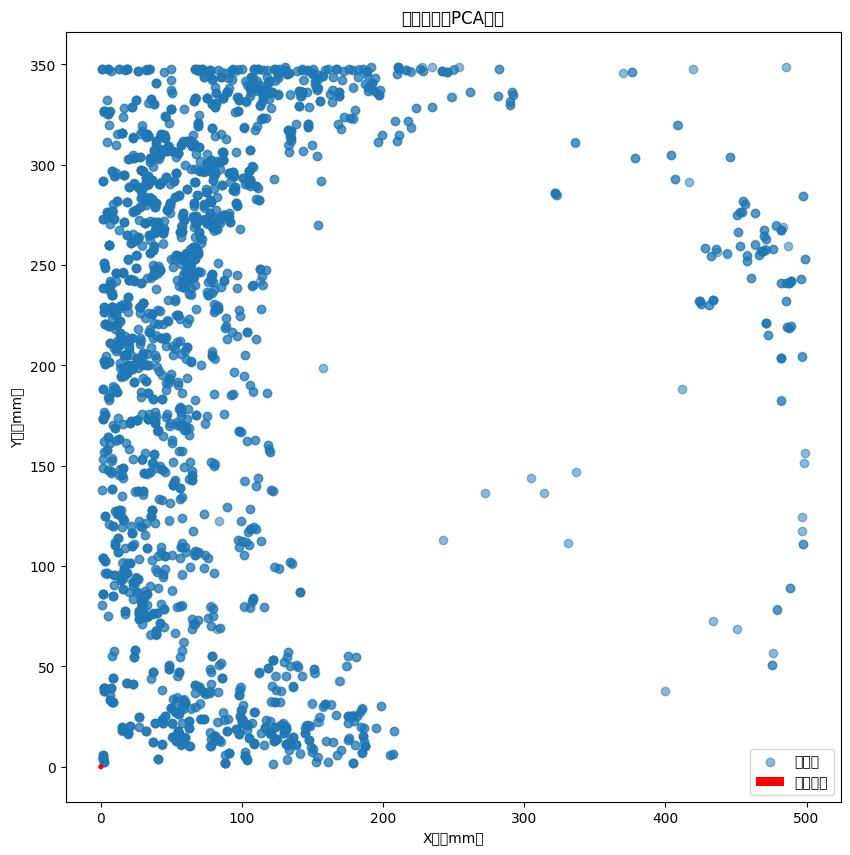

In [18]:
# 加载图像
image1 = cv2.imread('/content/drive/My Drive/SAND_TEST/T_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/My Drive/SAND_TEST/T_2.jpg', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('/content/drive/My Drive/SAND_TEST/T_3.jpg', cv2.IMREAD_GRAYSCALE)

# 获取图像尺寸
img_height, img_width = image1.shape

# 实际宽度和高度（单位：mm）
real_width = 500
real_height = 350

# 定义一个函数来找到图像中的关键点
def find_keypoints(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# 在所有图像中找到关键点和描述符
kp1, des1 = find_keypoints(image1)
kp2, des2 = find_keypoints(image2)
kp3, des3 = find_keypoints(image3)

# 使用BFMatcher找到图像之间的最佳匹配
bf = cv2.BFMatcher()
matches12 = bf.knnMatch(des1, des2, k=2)
matches23 = bf.knnMatch(des2, des3, k=2)

# 应用比率测试以保留好的匹配
good_matches12 = [m for m, n in matches12 if m.distance < 0.75 * n.distance]
good_matches23 = [m for m, n in matches23 if m.distance < 0.75 * n.distance]

# 提取好的匹配点的位置
def get_match_points(keypoints1, keypoints2, matches):
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
    return pts1, pts2

pts1_2, pts2_2 = get_match_points(kp1, kp2, good_matches12)
pts2_3, pts3_3 = get_match_points(kp2, kp3, good_matches23)

# 连接所有匹配点以进行PCA分析
all_points = np.concatenate((pts1_2, pts2_2, pts2_3, pts3_3), axis=0)

# 将图像坐标转换为实际物理距离
all_points[:, 0] *= (real_width / img_width)
all_points[:, 1] *= (real_height / img_height)

# 执行PCA分析
pca = PCA(n_components=2)
transformed_points = pca.fit_transform(all_points)

# 计算主要成分的均值，代表沙丘的移动
mean_movement = np.mean(transformed_points, axis=0)

# 获取PCA的两个主成分方向向量
principal_directions = pca.components_

# 计算主要成分在原始坐标系中的表示
mean_movement_original = np.dot(mean_movement, principal_directions)

print("x方向的实际移动距离（mm）: ", mean_movement_original[0])
print("y方向的实际移动距离（mm）: ", mean_movement_original[1])

# 绘制结果
plt.figure(figsize=(10, 10))
plt.scatter(all_points[:, 0], all_points[:, 1], alpha=0.5, label='关键点')
plt.quiver(0, 0, mean_movement_original[0], mean_movement_original[1], angles='xy', scale_units='xy', scale=1, color='r', label='移动方向')
plt.title('沙丘移动的PCA分析')
plt.xlabel('X轴（mm）')
plt.ylabel('Y轴（mm）')
plt.legend()
plt.show()


In [11]:
# 初始化一个列表来保存移动距离
displacements = []

# 遍历PCA结果，计算每两个连续图片之间的距离
for i in range(len(pca_result) - 1):
    # 计算第i张图片和第i+1张图片之间的距离
    displacement = pca_result[i+1] - pca_result[i]
    displacements.append(displacement)

# 输出每对图片间的移动距离
for i, displacement in enumerate(displacements):
    print(f"Displacement from image {i} to image {i+1}: x={displacement[0]}, y={displacement[1]}")

Displacement from image 0 to image 1: x=-37204.61864201802, y=33930.42404245213
Displacement from image 1 to image 2: x=-23839.281153237986, y=-39272.96143793405
